In [2]:
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import requests
import tarfile  # Unzip `.tar` file.

In [ ]:
# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
print(Path.cwd())

/root/jupyter_projects/PyTorch-Zoo/CNN with Flowers102 Dataset


In [2]:
# Change this to your own directory.
ROOT_DIR = Path("/root/jupyter_projects")  # Your working directory.
DATASET_DIR = ROOT_DIR / "Data"  # Directory where the datasets are/should be downloaded.
CHECKPOINT_DIR = ""  # Directory where the pretrained models are saved.

DATA_DIR = DATASET_DIR / "Flowers102"

DATA_DIR.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist.

In [3]:
image_dir = DATA_DIR / "oxford-102-flowers"

train_label_path = DATA_DIR / "oxford-102-flowers/train.txt"
val_label_path = DATA_DIR / "oxford-102-flowers/valid.txt"
test_label_path = DATA_DIR / "oxford-102-flowers/test.txt"

In [54]:
if not image_dir.is_dir():
    # Download dataset
    URL = "https://bucket-oranges-1310562101.cos.ap-guangzhou.myqcloud.com/Flowers102.tgz"  # Dropbox Link: https://www.dropbox.com/s/hqiryv0g62lp878/oxford-102-flowers.tgz?raw=1
    file_name = "Flowers102.tgz"
    file_path = DATA_DIR / file_name  # Download file path.

    try:
        r = requests.get(URL, allow_redirects=True)
        open(file_path, 'wb').write(r.content)
        print('[Success] Dataset downloaded successfully')
    except:
        print('[Error] Dataset downloaded failed')
        raise

    # Unzip dataset
    zip_file_path = file_path
    extract_directory = DATA_DIR
    
    try:
        with tarfile.open(zip_file_path, "r") as tar_ref:
            tar_ref.extractall(extract_directory)
        print('[Success] Dataset extracted successfully')
    except:
        print('[Error] Dataset extracted failed')
        raise
        
    Path.unlink(file_path)  # Remove zip file.
else:
    print('[Alert] Dataset already exist')

Dataset already exist!


### Create Dataset

In [49]:
def create_dataset(image_dir, label_path):
    path_list = []  # Store the path of image.
    class_list = []  # Store the class name.

    with open(label_path) as file:  # Get the content of label file.
        lines = file.readlines()

    for line in lines:
        image_path, image_class = line.strip().split(' ')
        image_path = str(image_dir / image_path)  # Convert to string type.
        path_list.append(image_path)  # Store the path of images in list.
        class_list.append(int(image_class))

    return path_list, class_list

In [5]:
train_path_list, train_class_list = create_dataset(image_dir, train_label_path)
val_path_list, val_class_list = create_dataset(image_dir, val_label_path)
test_path_list, test_class_list = create_dataset(image_dir, test_label_path)

In [6]:
print(len(train_path_list))
print(len(val_path_list))
print(len(test_path_list))

1020
1020
6149


In [41]:
class Flowers102Dataset(Dataset):
    def __init__(self, image_paths, image_class, transform=None):
        self.image_paths = image_paths
        self.image_class = image_class
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        
        # For numpy array:
        # image = cv2.imread(image_filepath)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # For torch tensor:
        image = torchvision.io.read_image(image_filepath)  # uint8 type
        image = image.to(torch.float)
        
        label = self.image_class[idx]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [42]:
img_transforms = transforms.Compose([
    transforms.CenterCrop(227),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [43]:
train_dataset = Flowers102Dataset(train_path_list, train_class_list, img_transforms)
val_dataset = Flowers102Dataset(val_path_list, val_class_list, img_transforms)
test_dataset = Flowers102Dataset(test_path_list, test_class_list, img_transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
torch.Size([3, 227, 227])
<class 'int'>
16


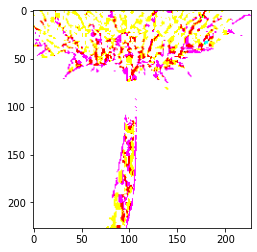

In [44]:
for X, y in train_dataset:
    print(type(X))
    print(X.shape)  # (channel, width, height)
    
    print(type(y))
    print(y)
    # plt.imshow(X.permute(1, 2, 0))
    break

In [45]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [46]:
for X, y in train_dataloader:
    print(X.shape)  # (bath, channel, width, height)
    print(y.shape)
    break

torch.Size([16, 3, 227, 227])
torch.Size([16])


In [47]:
NUM_CLASSES = 102

In [31]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = NUM_CLASSES, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),  # !
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [32]:
alexnet = AlexNet()

if torch.cuda.is_available():
    alexnet.cuda()

In [33]:
summary(alexnet, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]          23,296
              ReLU-2           [-1, 64, 56, 56]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [34]:
seed = torch.initial_seed()
print('*Used seed : {}*'.format(seed))  # seed value

*Used seed : 2312933560076547320*


In [35]:
optimizer = optim.Adam(params=alexnet.parameters(), lr=0.0001)
print('Optimizer created')

Optimizer created


In [36]:
loss_fn = nn.CrossEntropyLoss()
print('Lost function created')

Lost function created


In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Define pytorch device.

In [38]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)  # Number of samples in training set.
    model.train()
    for batch, (X, y) in enumerate(dataloader):  # Iterations.
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error.
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        
        # Backpropagation.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)  # Iteration * Batch Size = Number of samples have being trained.
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [39]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)  # Total number of samples in test set.
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 5
model = alexnet

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)
print("Done!")